In [16]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Auto reload of library
%reload_ext autoreload
%autoreload 2

# Python path
import sys
base_folder = 'DataScience'
location_base = os.path.join(os.getcwd().split(base_folder)[0], base_folder)
location_module = [os.path.join(location_base, 'Module')] 
for each in location_module:
    if each not in sys.path:
        sys.path.append(each)
        
from import_KK import *
DeviceStrategy_GPU()
from preprocessing_KK import *
from preprocessing_text_KK import * ##
from visualization_KK import * ##
from algorithm_BERT_KK import *
from evaluation_KK import *


Tensorflow Version:  2.10.0
Keras Version:  2.10.0
Num of Physical GPUs Available:  1
Cuda is Ready?  True
Cuda Version:  64_112
Cudnn Version:  64_8 

Torch Version:  2.1.0
Torch Cuda Version: 11.8
Torch Cudnn Version:8700
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4070 Laptop GPU


# Hyperparameters

In [17]:
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_LABELS = 3
SEQ_LEN = 64
BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 2.0e-5
MODEL_NAME = 'bert-base-multilingual-cased'    # 'bert-base-multilingual-cased', 'klue/roberta-base', 'monologg/kobert'
TOKENIZER = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)  
BESTMODEL_LOCATION = os.path.join(r'C:\Users\KK\Desktop\Model', 
                                  'modeling_BERTsentiment_'+datetime.datetime.now().strftime("%Y%m%d")+'.pt')

# Data Preprocessing

In [3]:
# 데이터 로딩
train = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'MovieReview_NSMC', 'ratings_train.txt'), sep='\t').sample(5000).reset_index().iloc[:,1:]
test = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'MovieReview_NSMC', 'ratings_test.txt'), sep='\t').sample(5000).reset_index().iloc[:,1:]

# 전처리
X_train, Y_train = train['document'], train['label']
X_test, Y_test = test['document'], test['label']
train_dataloader = preprocessing_sentence_to_BERTinput(TOKENIZER, X_train, Y_train, 
                                                       seq_len=SEQ_LEN, batch_size=BATCH_SIZE)
valid_dataloader = preprocessing_sentence_to_BERTinput(TOKENIZER, X_test, Y_test,
                                                       seq_len=SEQ_LEN, batch_size=BATCH_SIZE)

# Modeling

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 2 =======


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:25<00:00,  3.14it/s]


Training Loss: 0.64  Accuracy: 0.66  Epoch Took: 0:00:25
Validation Loss: 0.54  Accuracy: 0.74  Epoch Took: 0:00:07

======== Epoch 2 / 2 =======


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:23<00:00,  3.32it/s]


Training Loss: 0.47  Accuracy: 0.79  Epoch Took: 0:00:24
Validation Loss: 0.51  Accuracy: 0.76  Epoch Took: 0:00:07


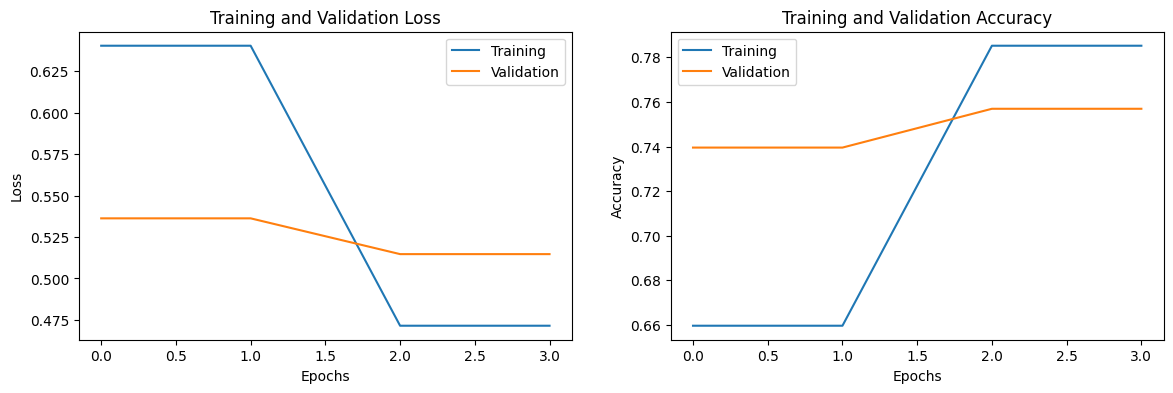


Training complete!


In [5]:
model = modeling_BERTsentiment(DEVICE, MODEL_NAME, train_dataloader, valid_dataloader, 
                               num_labels=NUM_LABELS, epochs=EPOCHS, learning_rate=LEARNING_RATE,
                               save_location=BESTMODEL_LOCATION)

# Prediction

In [19]:
# 예측 데이터 로딩
df_news = pd.read_csv(r'C:\Users\KK\Desktop\Data\df_news_bigkinds.csv')
DELETE_KEYWORD = ['100세', '거주환경']
keyword_filter = [each for each in df_news['Folder_Name'].unique() if each not in DELETE_KEYWORD]
df_news = df_news[df_news['Folder_Name'].apply(lambda x: x in keyword_filter)].reset_index().iloc[:,1:]
CATEGORY_BK_Sub = ['경제>경제일반', '경제>국제경제', '경제>취업_창업',
                   '사회>노동_복지', '사회>사건_사고', '사회>사회일반', '사회>여성', '사회>장애인', '사회>의료_건강',
                   '문화>미술_건축', '문화>요리_여행', '문화>출판',
                   '국제>중국', '국제>유럽_EU', '국제>일본', '국제>미국_북미', '국제>중동_아프리카',
                   '국제>아시아', '국제>중남미', '국제>국제일반', '국제>러시아']
category_filter = [each for each in df_news['통합 분류1'].unique() if each in CATEGORY_BK_Sub]
df_news = df_news[df_news['통합 분류1'].apply(lambda x: x in category_filter)].reset_index().iloc[:,1:]

In [29]:
def predict_sentiment_BERT(tokenizer, sentences,
                           seq_len=128, batch_size=32):
    # 문장을 입력 데이터로 변환
    test_dataloader = preprocessing_sentence_to_BERTinput(tokenizer, sentences, [],
                                                          seq_len=seq_len, batch_size=batch_size, sampler=None)

    # 예측
    model.eval()
    for batch_id, (tokens, masks) in enumerate(tqdm(test_dataloader)):
        b_input_ids = tokens.to(device)
        b_input_mask = masks.to(device)
        with torch.no_grad():    # 그래디언트 계산 안함
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    # Forward 수행

        # 출력
        logits = outputs[0].cpu().numpy()
    
    # 정리
    probability = pd.DataFrame(softmax(logits), columns=['Prob_Label'+str(i) for i in range(np.shape(logits)[1])])
    sentiment = pd.DataFrame(np.argmax(softmax(logits), axis=1), columns=['Sentiment'])
    
    return pd.concat([pd.Series(sentences), probability, sentiment], axis=1)

# 예측
# 모델 로딩
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(DEVICE)
model.load_state_dict(torch.load(BESTMODEL_LOCATION))
predict_sentiment_BERT(TOKENIZER, df_news['제목'][:10], seq_len=SEQ_LEN, batch_size=BATCH_SIZE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.78it/s]


,제목,Prob_Label0,Prob_Label1,Prob_Label2,Sentiment
0,시진핑 리스크까지 중진국 함정 빠지나,0.8930,0.1019,0.0051,0
1,출산율 07명도 위태 저출산 예산 176조로,0.8347,0.1598,0.0055,0
2,합계출산율 07명도 위태 내년 저출산 예산 176조원으로 확대,0.7663,0.2273,0.0064,0
3,늙어가는 울산 고령화에도 의료 수준 열악,0.5372,0.4587,0.0042,0
4,늙어가는 울산 고령화에도 의료수준 열악,0.4841,0.5117,0.0041,1
5,98세에도 강단 서는 영원한 학자 후학들에 지혜와 용기를 전하다 weekend 헬스,0.1117,0.8836,0.0047,1
6,광명시 노인정책 발굴,0.3872,0.6060,0.0068,1
7,4000만원으로 18세 국제결혼 매매혼 vs 축하 시끌,0.1088,0.8836,0.0077,1
8,윤영호의 퍼스펙티브 금융자산 관리하듯 건강자산 관리해야 웰빙 삶 가능,0.2645,0.7309,0.0046,1
9,고령화에 불붙는 정년연장론 청년층 밥그릇 뺏기 지적도,0.8376,0.1579,0.0045,0
